In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
from sklearn.metrics import *
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'


# define the hyper-parameters
batch_size = 1000
learning_rate = 1e-3
num_epoches = 70
loss_list = [] #  save loss
accuracy_list = [] # save accuracy
iteration_list = []


output_prob = []

In [2]:
# download the FashionMNIST dataset

train_dataset = datasets.FashionMNIST(
    root='./data/FashionMNIST', train=True, transform=transforms.ToTensor(), download=True)

test_dataset = datasets.FashionMNIST(
    root='./data/FashionMNIST', train=False, transform=transforms.ToTensor(),
    download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
# check the class types and labels

class_names = train_dataset.classes 
print(class_names)
print(train_dataset.data.shape)
print(test_dataset.data.shape)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [4]:
BATCH_SIZE = 32 
EPOCHS = 1

In [5]:
#computing vector embeddings for finite sets of items.

import pymde

fashion_mnist = pymde.datasets.FashionMNIST()
# embedding = pymde.preserve_neighbors(fashion_mnist.data, verbose=True).embed()
# pymde.plot(embedding, color_by=fashion_mnist.attributes['class'])

In [6]:
fashion_mnist

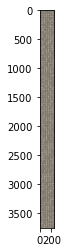

In [7]:
images, labels = next(iter(test_loader))

#  show some samples of data 

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225]) 
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) 
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
    
out = torchvision.utils.make_grid(images)

imshow(out)

In [8]:
import torch.nn.functional as F

# define the CNN model
class LeNetVariant(nn.Module):
    def __init__(self):
        super(LeNetVariant, self).__init__()
        self.features = nn.Sequential(
            # Convolutional layer #1.
            # Input image size 28x28x1
            # Computes 16 features using a 5x5 filter with ReLU activation.
            # Output image size 24x24x16
            # Pooling Layer #1.
            # First max pooling layer with a 2x2 filter and stride of 2.
            # Output image size 12x12x16
            nn.Conv2d(1, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # Convolutional layer #2.
            # Input image size 12x12x16
            # Computes 32 features using a 5x5 filter with ReLU activation.
            # Output image size 8x8x32
            # Pooling Layer #2.
            # Second max pooling layer with a 2x2 filter and stride of 2.
            # Output image size 4x4x32
            nn.Conv2d(16, 32, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d()
        )
        # First Fully-Connected to create 32 vectors, each one with 32x4x4=512 length
        self.classifier = nn.Sequential(nn.Linear(32 * 4 * 4, 32))

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 32 * 4 * 4 )
        x = self.classifier(x)
        return x

# define the CNN+LSTM model
class CNNLSTM(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNLSTM, self).__init__()
        self.cnn = LeNetVariant()
        # lstm layer
        # Input size 32x512
        # Output size 160
        self.lstm = nn.LSTM(input_size=32, hidden_size=160, num_layers=1,
                            batch_first=True)
        # Second Fully-Connected to create num_classes vectors, each one with 160 length
        self.fc1 = nn.Linear(160, num_classes)

    def forward(self, x_3d):
        cnn_output_list = list()
        for t in range(x_3d.size(1)):
            cnn_output_list.append(self.cnn(x_3d[:, t, :, :, :]))
        x = torch.stack(tuple(cnn_output_list), dim=1)
        out, hidden = self.lstm(x)
        x = out[:, -1, :]
        x = F.relu(x)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

In [9]:
# define the train steps
def train_loop(dataloader, model, loss_fn, optimizer, which_model):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.unsqueeze(1)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        

# define the test steps
def test_loop(dataloader, model, loss_fn, which_model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
        
            X = X.unsqueeze(1)
            pred = model(X)
            output_prob.append(pred.tolist())
            
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    loss_list.append(test_loss)
    accuracy_list.append(correct * 100)
    
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.2f}%, "
          f"Avg loss: {test_loss:>8f} \n")

In [10]:
# Start to train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNLSTM(num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


for t in range(num_epoches):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, 2)
    test_loop(test_loader, model, loss_fn, 2)
    print("Done!")
    
    
# Save Models
torch.save(model.state_dict(), "cnnlstm.pth")
print("Saved PyTorch Model State to cnnlstm.pth")

Epoch 1
-------------------------------
loss: 2.303082  [    0/60000]
loss: 1.128858  [50000/60000]
Test Error: 
 Accuracy: 65.24%, Avg loss: 1.046570 

Done!
Epoch 2
-------------------------------
loss: 1.029684  [    0/60000]
loss: 0.784072  [50000/60000]
Test Error: 
 Accuracy: 72.31%, Avg loss: 0.768041 

Done!
Epoch 3
-------------------------------
loss: 0.738193  [    0/60000]
loss: 0.662574  [50000/60000]
Test Error: 
 Accuracy: 75.09%, Avg loss: 0.658737 

Done!
Epoch 4
-------------------------------
loss: 0.608128  [    0/60000]
loss: 0.588015  [50000/60000]
Test Error: 
 Accuracy: 77.46%, Avg loss: 0.589437 

Done!
Epoch 5
-------------------------------
loss: 0.522540  [    0/60000]
loss: 0.547995  [50000/60000]
Test Error: 
 Accuracy: 78.32%, Avg loss: 0.552187 

Done!
Epoch 6
-------------------------------
loss: 0.484015  [    0/60000]
loss: 0.510935  [50000/60000]
Test Error: 
 Accuracy: 79.85%, Avg loss: 0.523831 

Done!
Epoch 7
-------------------------------
loss: 

loss: 0.224387  [50000/60000]
Test Error: 
 Accuracy: 88.98%, Avg loss: 0.297301 

Done!
Epoch 53
-------------------------------
loss: 0.227910  [    0/60000]
loss: 0.226956  [50000/60000]
Test Error: 
 Accuracy: 89.29%, Avg loss: 0.294861 

Done!
Epoch 54
-------------------------------
loss: 0.217933  [    0/60000]
loss: 0.234354  [50000/60000]
Test Error: 
 Accuracy: 89.00%, Avg loss: 0.297738 

Done!
Epoch 55
-------------------------------
loss: 0.218514  [    0/60000]
loss: 0.216231  [50000/60000]
Test Error: 
 Accuracy: 88.88%, Avg loss: 0.295518 

Done!
Epoch 56
-------------------------------
loss: 0.217063  [    0/60000]
loss: 0.222766  [50000/60000]
Test Error: 
 Accuracy: 89.40%, Avg loss: 0.290149 

Done!
Epoch 57
-------------------------------
loss: 0.219622  [    0/60000]
loss: 0.226750  [50000/60000]
Test Error: 
 Accuracy: 89.35%, Avg loss: 0.293229 

Done!
Epoch 58
-------------------------------
loss: 0.206755  [    0/60000]
loss: 0.220879  [50000/60000]
Test Error

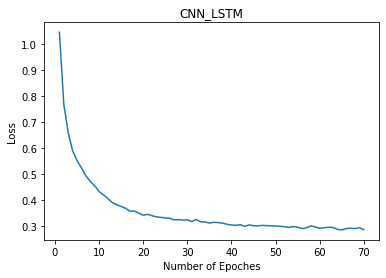

In [11]:
# draw the graph of the loss

for i in range(num_epoches):
    iteration_list.append(i+1)

plt.plot(iteration_list, loss_list)
plt.xlabel('Number of Epoches')
plt.ylabel('Loss')
plt.title('CNN_LSTM')
plt.show()

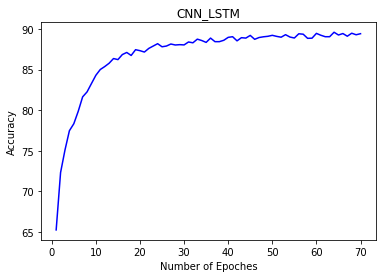

In [12]:
# draw the graph of the accuracy

plt.plot(iteration_list, accuracy_list, color='b')
plt.xlabel('Number of Epoches')
plt.ylabel('Accuracy')
plt.title('CNN_LSTM')
#plt.savefig('LSTM_accuracy2.png')
plt.show()

In [13]:
# Compute the confusion matrix and F1_score, Acc, Recall_rate, and Precision

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            
            data = data.unsqueeze(1)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, device, test_loader)
k = confusion_matrix(actuals, predictions)
print('Confusion matrix:')
print(k)
print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))
print('Recall score: %f' % recall_score(actuals, predictions, average='micro'))
print('Precision score: %f' % precision_score(actuals, predictions, average='weighted'))

Confusion matrix:
[[884   0  18  16   4   1  69   0   8   0]
 [  1 982   0  10   2   0   3   0   2   0]
 [ 19   0 881   8  42   0  50   0   0   0]
 [ 20   4  10 924  19   0  20   0   3   0]
 [  1   1  74  29 833   0  61   0   1   0]
 [  0   0   0   0   0 988   0   5   0   7]
 [141   1  75  26  52   0 694   0  11   0]
 [  0   0   0   0   0  27   0 938   0  35]
 [  3   2   8   1   3   1   1   2 978   1]
 [  0   0   0   0   0   8   0  21   0 971]]
F1 score: 0.907300
Accuracy score: 0.907300
Recall score: 0.907300
Precision score: 0.906922


In [14]:
np.shape(predictions)

(10000,)

In [15]:
np.shape(output_prob)

(700, 1000, 10)

In [16]:
out_prob = np.reshape(output_prob[(num_epoches-1)*10:num_epoches*10][:][:],(-1, 10))

In [17]:
np.shape(out_prob)

(10000, 10)

In [18]:
import pandas as pd
out_prob = pd.DataFrame(out_prob)

In [19]:
actuals = pd.DataFrame(actuals)
actuals.to_csv('actual_label_LSTM.csv', sep = ',')

In [20]:
np.exp(out_prob).to_csv('output_prob_LSTM.csv', sep = ',')

In [21]:
print(classification_report(actuals, predictions))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.83      0.88      0.85      1000
           3       0.91      0.92      0.92      1000
           4       0.87      0.83      0.85      1000
           5       0.96      0.99      0.98      1000
           6       0.77      0.69      0.73      1000
           7       0.97      0.94      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.97      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



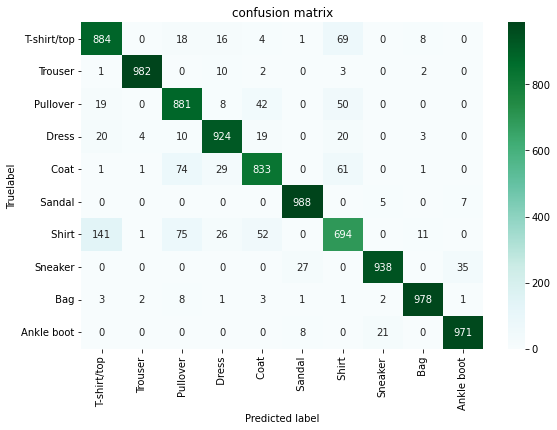

In [22]:
#draw the heatmap of confusion matrix

import pandas as pd
import seaborn as sns
# Display the confusion matrix as a heatmap
class_names = ['T-shirt/top', 'Trouser', 'Pullover', '  Dress', ' Coat', '  Sandal', ' Shirt', 'Sneaker', ' Bag', 'Ankle boot']
df_cm = pd.DataFrame(k, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Predicted label")
plt.ylabel("Truelabel")
plt.title("confusion matrix")
plt.show()

The area under the ROC curve: 0.974756


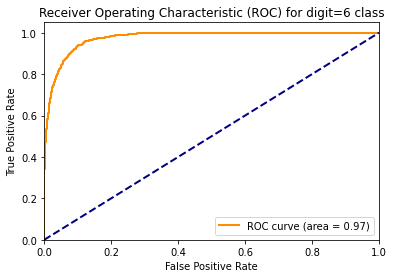

In [23]:
#check the ROC and AUROC of a class

import numpy as np


which_class = 6
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.unsqueeze(1)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            #setting the target tensor size to same as prediction tensor size
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

actuals, class_probabilities = test_class_probabilities(model, device, test_loader, which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr) #Compute the area under the ROC curve.
print('The area under the ROC curve: %f' % roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for digit=%d class' % which_class)
plt.legend(loc="lower right")
plt.show()
#plt.savefig("ROC.png")

In [24]:
# fashion_mnist = pymde.datasets.FashionMNIST()
# embedding = pymde.preserve_neighbors(fashion_mnist.data, verbose=True).embed()
# pymde.plot(embedding, color_by=mnist.attributes['class'])